In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

/Users/deliad/opt/anaconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
PATH = "./housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [3]:
y = np.log1p(df['median_house_value']).values
del df['median_house_value']
X_full_train, X_test, y_full_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=1)


In [4]:
dicts = X_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)
dicts = X_val.to_dict(orient='records')
X_val = dv.fit_transform(dicts)

In [5]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [6]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/Users/deliad/opt/anaconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [7]:
rf = RandomForestRegressor(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [16]:
y_pred = rf.predict(X_val)
RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
round(RMSE, 2)

0.25

In [18]:
estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
for n in estimators:
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
    print(round(RMSE, 5))

0.24579
0.23915
0.23565
0.23454
0.23305
0.23292
0.2325
0.23257
0.23222
0.23194
0.23148
0.2316
0.2317
0.23168
0.23171
0.23167
0.23161
0.23178
0.23179
0.23166


In [32]:
%%capture --no-display
estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
depth = [10, 15, 20, 25]
best = pd.DataFrame(columns=["depth", "estimators", "RMSE"])
for d in depth:
    for n in estimators:
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
        best = best.append({'depth':d, 'estimators':n, 'RMSE':(round(RMSE, 5))}, ignore_index=True)

In [33]:
best

,depth,estimators,RMSE
0,10.0,10.0,0.25460
1,10.0,20.0,0.25260
2,10.0,30.0,0.25151
3,10.0,40.0,0.25096
4,10.0,50.0,0.25012
...,...,...,...
75,25.0,160.0,0.23149
76,25.0,170.0,0.23145
77,25.0,180.0,0.23158
78,25.0,190.0,0.23155


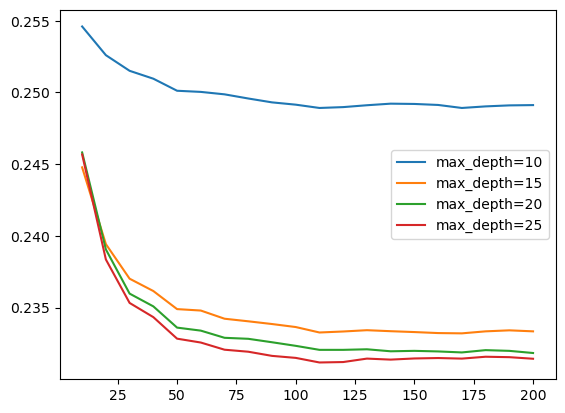

In [41]:
for d in [10, 15, 20, 25]:
        best_subset = best[best.depth == d]
        plt.plot(best_subset.estimators, best_subset.RMSE, label='max_depth=%d' % d)
plt.legend()

In [42]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, random_state=1)

In [48]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=dv.get_feature_names())
forest_importances.sort_values()

/Users/deliad/opt/anaconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


ocean_proximity=ISLAND        0.000357
ocean_proximity=NEAR BAY      0.000453
ocean_proximity=<1H OCEAN     0.002765
ocean_proximity=NEAR OCEAN    0.004452
households                    0.016141
total_bedrooms                0.019373
total_rooms                   0.020465
population                    0.030999
housing_median_age            0.033197
longitude                     0.096341
latitude                      0.101333
ocean_proximity=INLAND        0.310901
median_income                 0.363224
dtype: float64

In [72]:
features = ['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [74]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,
    'eval_metric': 'rmse',
    'seed': 1,
    'verbosity': 1,
}

xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=100)

In [75]:
def parse_xgb_output(output):
    results = []
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))
        
    columns = ['iter_num', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [77]:
parse_xgb_output(output).sort_values(by='val_rmse')

,iter_num,train_rmse,val_rmse
85,85,0.14166,0.22579
86,86,0.14128,0.22582
83,83,0.14298,0.22589
82,82,0.14386,0.22595
84,84,0.14244,0.22598
...,...,...,...
4,4,1.97833,1.98175
3,3,2.80712,2.81079
2,2,3.99539,4.00041
1,1,5.69586,5.70070


In [79]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,
    'eval_metric': 'rmse',
    'seed': 1,
    'verbosity': 1,
}

xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=100)

In [80]:
parse_xgb_output(output).sort_values(by='val_rmse')

,iter_num,train_rmse,val_rmse
99,99,0.18329,0.23054
98,98,0.18385,0.23057
97,97,0.18405,0.23067
96,96,0.18470,0.23089
94,94,0.18586,0.23104
...,...,...,...
4,4,6.85878,6.86368
3,3,7.61859,7.62391
2,2,8.46290,8.46831
1,1,9.40118,9.40684
